In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [12]:
import sunradiation as sun
import weatherfeed as wf
import emoncmsfeed as getfeeds

# Téléchargement des données et premier traitement

In [13]:
coords_grenoble = (45.1973288, 5.7139923)

startday = pd.to_datetime('12/07/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')
lastday = pd.to_datetime('now').tz_localize('Europe/Paris')

## Météo Darksky
J'utilise l'API de DarkSky (https://darksky.net).

In [14]:
# routine pour construire automatiquement un dataframe pandas:
# télécharge les données en ligne
weatherdata = wf.buildmultidayDF(startday, lastday, coords_grenoble )

12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, done


Ce sont des données heure par heure. Pour avoir une meillieur précision avec les données mesurées et le flux solaire, on augmente artificiellment la fréquence à 15min:

In [15]:
weatherdata = weatherdata.resample('15min').interpolate('linear')

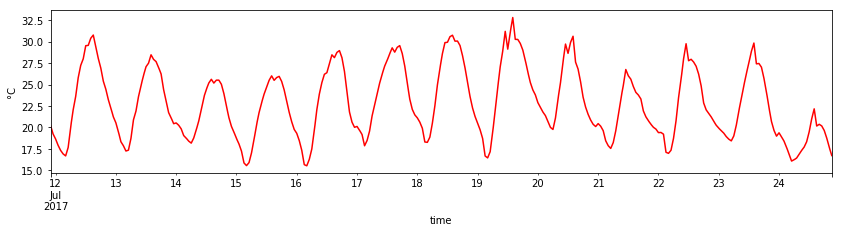

In [16]:
weatherdata['temperature'].plot(figsize=(14, 3), color='r' );  plt.ylabel('°C');

## Irradiation solaire

Routine permettant d'obtenir :

* Le flux (W/m2) sur une surface perpendiculaire au rayon du soleil, en prennant en compte la couverture nuageuse.
* La position du soleil (altitude et azimuth) pour projeter sur les vitres ensuite. 

Il n'y a pas la radiation diffuse, mais prend en compte la couverture nuageuse ( $ 0.75*c^3.4 $ ... )

In [17]:
sundata = sun.buildmultidayDF( coords_grenoble, weatherdata.index, cloudCover = weatherdata['cloudCover']  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


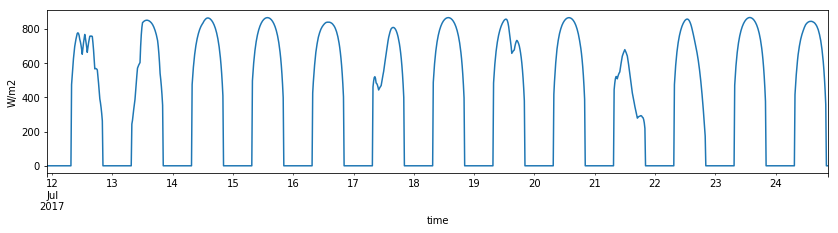

In [18]:
sundata['I0'].plot(figsize=(14, 3));  plt.ylabel('W/m2');

### Projection sur les surfaces vitrées

In [19]:
# surface (m2),  sigma (deg),  azimuth (deg)
windows = { 'bastille':(1.2*0.8,    37, 50) ,
            'cuisine':(0.3*0.72 *2, 90, 50 ),
            'chambre':(0.3*0.72 *2, 90, 180+50),
            'vercors':(0.6*0.8 * 2, 37, 180+50) }

In [20]:
sunFlux_dict = {}

for k, values in windows.items():
    sunFlux_dict['flux_'+k] = values[0] * sun.projectDF( values[1], values[2], sundata )

flux_tot = pd.DataFrame( sunFlux_dict )

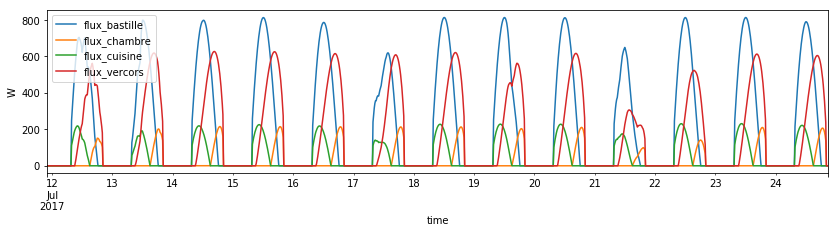

In [21]:
flux_tot.plot(figsize=(14, 3)); plt.ylabel('W');

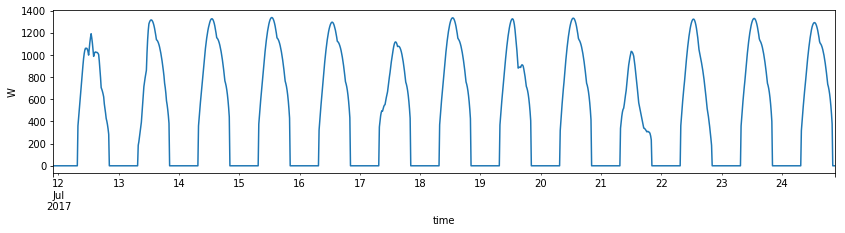

In [22]:
# Somme
weatherdata['flux_tot'] = flux_tot.sum(axis=1)

weatherdata['flux_tot'].plot( figsize=(14, 3) ); plt.ylabel('W');

**Rq:** C'est le flux 'brut' reçu par les surfaces. Il faut ensuite prendre en compte la réflexion, l'absorption et la ré-émission ... ceci étant décrit par un facteur multiplicatif entre 0 et 1, noté facteur_g. [wiipedia](https://fr.wikipedia.org/wiki/Vitre#Le_facteur_solaire_g_ou_transmission_.C3.A9nerg.C3.A9tique)

Au minimum, on a $facteur_g = 0.76$ pour un double vitrage. Il y a aussi l'absorption par le cadre (et les rideaux) et la transmision par conduction, et re-émissions. 


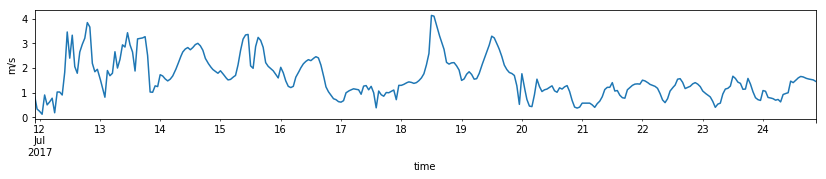

In [23]:
# Vitesse du vent
weatherdata['windSpeed'].plot(figsize=(14, 2));  plt.ylabel('m/s');

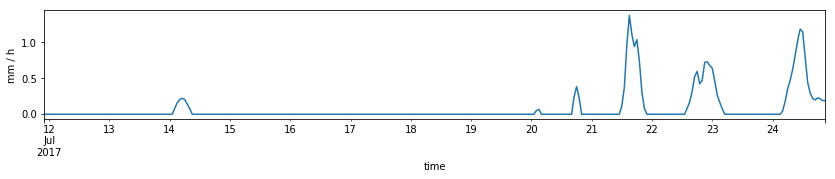

In [24]:
# Pluie
weatherdata['precipIntensity'].plot(figsize=(14, 2)); plt.ylabel('mm / h');

# Température intérieure mesurée

Téléchargement depuis EmonCMS

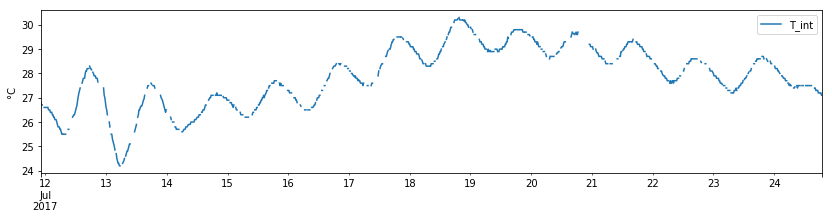

In [25]:
dataframefreq = '15min'
feeds =  { 'T_int': 3 }

Tmesure = getfeeds.builddataframe( feeds, dataframefreq , startdate=startday )
Tmesure.plot( figsize=(14, 3) ); plt.ylabel('°C');

In [26]:
# Remove some data 
mask_start = pd.to_datetime( '28/06/2017 22:00' ).tz_localize('Europe/Paris')
mask_end = pd.to_datetime( '29/06/2017 10:00' ) .tz_localize('Europe/Paris')

mask = (Tmesure.index > mask_start) & (Tmesure.index < mask_end )

Tmesure['T_int'].loc[mask] = np.nan

In [27]:
# Resample
Tmesure = Tmesure.resample('15min').mean()

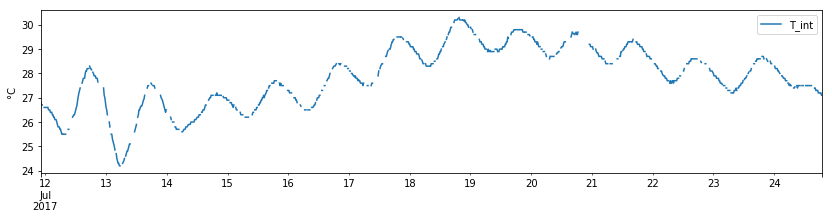

In [28]:
Tmesure.plot( figsize=(14, 3) ); plt.ylabel('°C');

In [29]:
# Merge
weatherdata['T_int'] = Tmesure['T_int']

# Enregistrement du Dataframe avec  Pickle

In [30]:
weatherdata.to_pickle( 'weatherdata.pck' )

# Graph

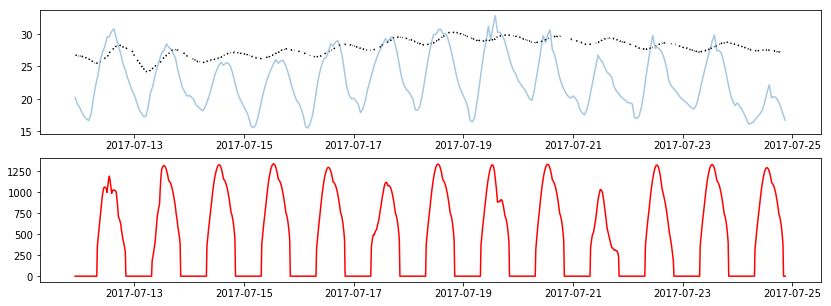

In [31]:
plt.figure( figsize=(14, 5) )
plt.subplot( 2, 1, 1 )
plt.plot(weatherdata['T_int'] , ':k')
plt.plot(weatherdata['temperature'], alpha=0.4);

plt.subplot( 2, 1, 2 )
plt.plot(weatherdata['flux_tot'] , 'r'); 
